# Task proposal

Practice and important concepts on how it is possible to process text and make the machine understand the correlation of words, phrases and document writing.

Video 1: [Natural Language Processing - Tokenization (NLP Zero to Hero - Part 1)](https://youtu.be/fNxaJsNG3-s?si=-YbqAQ9E_Q_20_T9) (4 minutes)

Video 2: [Natural Language Processing with spaCy & Python - Course for Beginners](https://youtu.be/dIUTsFT2MeQ?si=E0R33-zCbThICIiu) (3 hours and 2 minutes)

# NLP Zero to Hero

## How to represent words to a computer

The process of bringing meaning to words from a computer's point of view is called tokenization. By matching each word in a sentence to a number, it is possible to have a program match each word in a sentence.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'i love my dog',
    'I, love my cat',
    'You love my dog!'
]

tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'love': 1, 'my': 2, 'i': 3, 'dog': 4, 'cat': 5, 'you': 6}


## Phrases in data


Once each word has a number, a sentence using the numbers must be assembled, so that it can be used in a machine learning model in the future, for example.


If there are words in the sentence that were not previously tokenized, they are ignored and skipped.

In [ ]:
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentences = [
    'I love my dog',
    'I love my cat',
    'You love my dog!',
    'Do you think my dog is amazing?'
]

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)

print(sequences)

[[3, 1, 2, 4], [3, 1, 2, 5], [6, 1, 2, 4], [6, 2, 4]]


If there are non-tokenized and ignored words, it is still possible to obtain the total length of the sentence using padding.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded = pad_sequences(sequences, maxlen=5)

print(padded)

[[0 3 1 2 4]
 [0 3 1 2 5]
 [0 6 1 2 4]
 [0 0 6 2 4]]


## Recognizing emotions

In the case below, a model is created capable of predicting the level of sarcasm present in a sentence, with the value 0 being non-sarcastic, and the value 1 being sarcastic.

In [ ]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Loading the data

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json


--2024-01-18 17:26:00--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2024-01-18 17:26:01 (48.9 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



Parameters for tokenization.

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

Transform data to python format.

In [ ]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

Separating between training and testing.

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

Tokenization.

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### Embedding

To bring the meaning of sarcasm to the problem, the last layer of the network has a neuron with a sigmoid activation function, which will bring values between 0 and 1, meaning sarcasm.

In other problems, the meaning abstracted by the model can be seen as axes in space, each of them being a feeling, and each sentence having values in each dimension, which are supplied to the model and added together, obtaining the multidimensional direction of the sentence, giving an idea of the present feeling.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

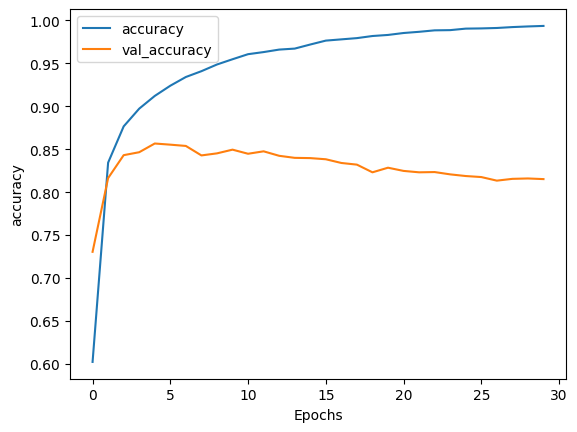

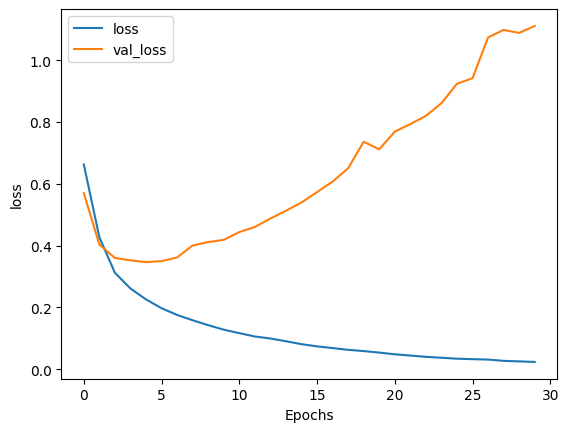

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 131ms/step
[[9.1189015e-01]
 [1.7776283e-06]]


According to the model's understanding, the first sentence is more sarcastic than the second.

## Text generation


When generating new words to compose a sentence, the model must consider the context present in it, that is, consider previously created or seen words. This type of model is called a recurrent neural network, which works with sequential data. This way, the model can bring meaning to the next words created. However, if it is necessary to bring context to previous and distant words, the ideal is to use a long short-term memory model.


### Irish Poem Creation

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2024-01-18 18:19:26--  https://storage.googleapis.com/learning-datasets/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.117.207, 142.250.99.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.117.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.005s  

2024-01-18 18:19:26 (13.5 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [ ]:
tokenizer = Tokenizer()

data = open('/tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)


{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

The code below divides the sentence into different items in the list, so that, instead of considering an entire sentence, it first considers a string with the first theme of the sentence, then with the first two items of the sentence, and so on. against.


This way, the last value present in the string serves as the label to be learned, while other items serve as input.

In [ ]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

It can be seen that, when obtaining the variable "ys" categorically, that is, creating different possible categories, and that obtained by a word being represented by the number one within these categories, the model will have to have in the last layer the equivalent number of neurons to the number of classes of y, or the total number of tokens.

In [ ]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])
print(tokenizer.word_index['jeremy'])
print(tokenizer.word_index['lanigan'])

8
1
71
6
713
39
1790
1791


In [ ]:
print(xs[6])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]


In [ ]:
print(ys[6])

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(xs[5])
print(ys[5])

[   0    0    0    0    0    0    0    0    0   51   12   96 1217   48
    2]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
print(tokenizer.word_index)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=100, verbose=1)
print(model)


In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

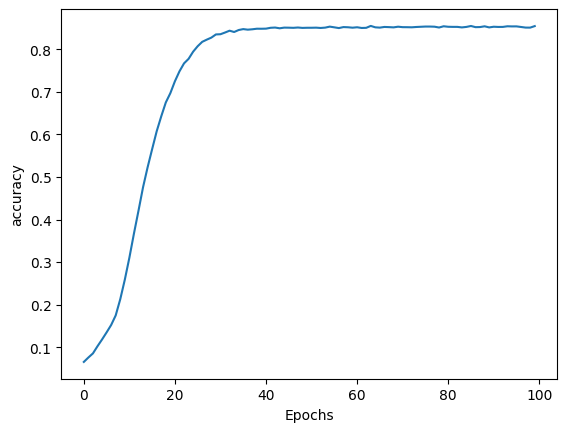

In [ ]:
plot_graphs(history, 'accuracy')


The code below takes as input a sentence and predicts the next 100 words. This process is done by predicting a word at each iteration, so that in the next iteration the sentence plus the last word made is passed to the model, thus forming an input for a new prediction of yet another word.

In [ ]:
seed_text = "I've got a bad feeling about this"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 18ms/step
I've got a bad feeling about this call round a cliffs of doneen tree of go town where spancil met english side town english grow english grow grand arms grand fathers eyes that immortal wives filled hardly wee mythology mythology mythology course constant distance nothing bouys small lower higher crazy praties politicians politicians king higher tenants crazy crazy crazy clear way derry gilgarra cornwall struggle struggle stay quitely marble wee who they died for she they ground hand would would run crazy know clear run frightened frightened mind again for to tarry then beside go home in derry joyous omalley there on til of all the night


# Natural Language Processing with spaCy & Python


The video is an introduction to Natural Language Processing (NLP) using the SpaCy library. Various applications of NLP are described, such as information extraction and text classification, and the benefits of spaCy for processing large amounts of data accurately and efficiently are explained. The course is divided into three parts, including an exploration of spaCy's out-of-the-box features spaCy and rules-based channels, as well as a lesson on applying NLP to extract information from financial documents.


Information extraction involves using NLP to extract relevant data from unstructured data such as raw text, which is different from the field of natural language understanding (NLU).

In [ ]:
!python -m spacy download en_core_web_sm

2024-01-19 16:36:20.788958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 16:36:20.789016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 16:36:20.790245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 16:36:21.963192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")

## Containers


Working with spaCy, containers are objects that store large amounts of information about a text, which have different types and are organized hierarchically.


These are: Doc, DocBin, Example, Language, Lexeme, Span, Spangroup and Token.


Hierarchically, the Doc container is the most important, and contains a lot of information about the text. For example, using the Doc object, you can extract sentences from a text. If you also want, the tokens can be iterated by the Doc, allowing access to words and punctuations.


Just below in the hierarchy, there are span objects, which can be one or multiple tokens. Below is SpanGroup.

In [ ]:
with open ("/content/sample_data/wiki_us.txt", "r") as f:
    text = f.read()

In [ ]:
print (text)

The United States of America (U.S.A. or USA), commonly known as the United States (U.S. or US) or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major unincorporated territories, 326 Indian reservations, and some minor possessions.[j] At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area.[d] The United States shares significant land borders with Canada to the north and Mexico to the south, as well as limited maritime borders with the Bahamas, Cuba, and Russia.[22] With a population of more than 331 million people, it is the third most populous country in the world. The national capital is Washington, D.C., and the most populous city is New York.

Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies est

Getting the text, it is fed to the nlp object created by spaCy, thus creating a doc.

In [ ]:
doc = nlp(text)

In [ ]:
print (doc)

The United States of America (U.S.A. or USA), commonly known as the United States (U.S. or US) or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major unincorporated territories, 326 Indian reservations, and some minor possessions.[j] At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area.[d] The United States shares significant land borders with Canada to the north and Mexico to the south, as well as limited maritime borders with the Bahamas, Cuba, and Russia.[22] With a population of more than 331 million people, it is the third most populous country in the world. The national capital is Washington, D.C., and the most populous city is New York.

Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies est

Although they look like the same thing, they are different in the sense that the text is a set of letters, and the docs object is a set of tokens, as shown below.

In [ ]:
print (len(text))
print (len(doc))

3521
654


In [ ]:
for token in text[0:10]:
    print (token)

T
h
e
 
U
n
i
t
e
d


In [ ]:
for token in doc[:10]:
    print (token)

The
United
States
of
America
(
U.S.A.
or
USA
)


### Sentence Boundary Detection

It's about identifying phrases in a text.

In [ ]:
for sent in doc.sents:
    print (sent)

The United States of America (U.S.A. or USA), commonly known as the United States (U.S. or US) or America, is a country primarily located in North America.
It consists of 50 states, a federal district, five major unincorporated territories, 326 Indian reservations, and some minor possessions.[j]
At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area.[d]
The United States shares significant land borders with Canada to the north and Mexico to the south, as well as limited maritime borders with the Bahamas, Cuba, and Russia.[22]
With a population of more than 331 million people, it is the third most populous country in the world.
The national capital is Washington, D.C., and the most populous city is New York.


Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century.
The United States emerged from the thirteen British colonies es

In [ ]:
sentence1 = list(doc.sents)[0]
print (sentence1)

The United States of America (U.S.A. or USA), commonly known as the United States (U.S. or US) or America, is a country primarily located in North America.


## Token assignments

Each token has metadata, which is accessed through its attributes

In [ ]:
token2 = sentence1[2]
print(token2)

States


In [ ]:
token2.text

'States'

In [ ]:
token2.left_edge

The

In [ ]:
token2.right_edge

America

It can be seen that the left and right edges are looking for information in the token2 span.

In [ ]:
token2.ent_type

384

Token entity, below shows as geo political entity.

In [ ]:
token2.ent_type_

'GPE'

Token entity, below shows as geo political entity. 'I' shows which token is inside the entity. The word "states" is inside another entity.

In [ ]:
token2.ent_iob_

'I'

Lemma_ makes it possible to extract the word/verb without any conjugation.

In [ ]:
token2.lemma_

'States'

In [ ]:
sentence1[12].lemma_

'know'

In [ ]:
print (sentence1[12])

known


In [ ]:
token2.morph

Number=Sing

In [ ]:
sentence1[12].morph

Aspect=Perf|Tense=Past|VerbForm=Part

In [ ]:
token2.pos_

'PROPN'

In [ ]:
token2.dep_

'nsubj'

In [ ]:
token2.lang_

'en'

In [ ]:
text = "Mike enjoys playing football."
doc2 = nlp(text)
print (doc2)

Mike enjoys playing football.


In [ ]:
for token in doc2:
    print (token.text, token.pos_, token.dep_)

Mike PROPN nsubj
enjoys VERB ROOT
playing VERB xcomp
football NOUN dobj
. PUNCT punct


## Named Entity Recognition

Information extraction subtask that seeks to find and classify named entities mentioned in unstructured text into predefined categories, such as person names, organizations, locations, doctors.

In [ ]:
for ent in doc.ents:
    print (ent.text, ent.label_)

The United States of America GPE
U.S.A. GPE
USA GPE
the United States GPE
U.S. GPE
US GPE
America GPE
North America LOC
50 CARDINAL
five CARDINAL
326 CARDINAL
Indian NORP
3.8 million square miles QUANTITY
9.8 million square kilometers QUANTITY
fourth ORDINAL
The United States GPE
Canada GPE
Mexico GPE
Bahamas GPE
Cuba GPE
more than 331 million CARDINAL
third ORDINAL
Washington GPE
D.C. GPE
New York GPE
Paleo-Indians NORP
Siberia LOC
North American NORP
at least 12,000 years ago DATE
European NORP
the 16th century DATE
The United States GPE
thirteen CARDINAL
British NORP
the East Coast LOC
Great Britain GPE
the American Revolutionary War ORG
the late 18th century DATE
U.S. GPE
North America LOC
Native Americans NORP
1848 DATE
the United States GPE
United States GPE
the second half of the 19th century DATE
the American Civil War ORG
Spanish NORP
World War EVENT
U.S. GPE
World War II EVENT
the Cold War EVENT
the United States GPE
the Korean War EVENT
the Vietnam War EVENT
the Soviet Union

In [ ]:
displacy.render(doc, style="ent", jupyter=True)

## Word Vectors


A way to bring meanings to words, different from the first part of this task, is to represent them multidimensionally through a vector, thus creating a new way of representing words. This way, it is also possible to relate different words in the same text.

In [ ]:
import spacy

en_core_web_md is a larger template that has word vectors.

In [ ]:
!python -m spacy download en_core_web_md

2024-01-23 18:25:10.006207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 18:25:10.006260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 18:25:10.007398: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 18:25:11.028734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
nlp = spacy.load("en_core_web_md")

In [ ]:
with open ("/content/wiki_us.txt", "r") as f:
    text = f.read()

In [ ]:
doc = nlp(text)
sentence1 = list(doc.sents)[0]
print (sentence1)

The United States of America (U.S.A. or USA), commonly known as the United States (U.S. or US) or America, is a country primarily located in North America.


In [ ]:
import numpy as np
your_word = "country"

ms = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[your_word]]]), n=10)
words = [nlp.vocab.strings[w] for w in ms[0][0]]
distances = ms[2]
print(words)

['country—0,467', 'nationâ\x80\x99s', 'countries-', 'continente', 'Carnations', 'pastille', 'бесплатно', 'Argents', 'Tywysogion', 'Teeters']


In [ ]:
doc1 = nlp("I like salty fries and hamburgers.")
doc2 = nlp("Fast food tastes very good.")

Way to compare sentences and find out their similarity. Also useful for relating different documents.

In [ ]:
print (doc1, "<->", doc2, doc1.similarity(doc2))

I like salty fries and hamburgers. <-> Fast food tastes very good. 0.691649353055761


In [ ]:
doc3 = nlp("The Empire State Building is in New York.")

In [ ]:
print (doc1, "<->", doc3, doc1.similarity(doc3))

I like salty fries and hamburgers. <-> The Empire State Building is in New York. 0.1766669125394067


In [ ]:
doc4 = nlp("I enjoy oranges.")
doc5 = nlp("I enjoy apples.")

In [ ]:
print (doc4, "<->", doc5, doc4.similarity(doc5))

I enjoy oranges. <-> I enjoy apples. 0.9775702131220241


In [ ]:
doc6 = nlp("I enjoy burgers.")

Although burger is a food, it is less similar because it is not a fruit.

In [ ]:
print (doc4, "<->", doc6, doc4.similarity(doc6))

I enjoy oranges. <-> I enjoy burgers. 0.9628306772893752


In [ ]:
french_fries = doc1[2:4]
burgers = doc1[5]
print(french_fries, "<->", burgers, french_fries.similarity(burgers))

salty fries <-> hamburgers 0.6938489675521851


## SpaCy Pipelines


In addition to functioning as an NLP framework, SpaCy also allows the creation of pipelines. A pipeline will be a sequence of data transformations, that is, different steps that the data has to go through, forming a 'pipeline' with different pipes.

In [ ]:
nlp = spacy.blank("en")

Senteceizer = separating sentences from a text.

In [ ]:
nlp.add_pipe("sentencizer")

In [ ]:
nlp.analyze_pipes()

{'summary': {'sentencizer': {'assigns': ['token.is_sent_start', 'doc.sents'],
   'requires': [],
   'scores': ['sents_f', 'sents_p', 'sents_r'],
   'retokenizes': False}},
 'problems': {'sentencizer': []},
 'attrs': {'doc.sents': {'assigns': ['sentencizer'], 'requires': []},
  'token.is_sent_start': {'assigns': ['sentencizer'], 'requires': []}}}

In [ ]:
nlp2 = spacy.load("en_core_web_sm")

In [ ]:
nlp2.analyze_pipes()

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False},
  'attribute_ruler': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False}},
 'problems': {'tok2vec': [],
  'tagger': [],
  'parser': [],
  'attribute_ruler': [],
  'lemmatizer': [],
  'ner': []},
 'att

Em resumo, com os pipelines você pode montar uma sequência própria do que fazer com os textos.

## SpaCy Entity Ruler

There are two ways to add custom actions to a pipeline. The first involves creating a set of rules that satisfy some objective, however, if it is not possible to create a rule because the problem is too complex, machine learning models can be trained to serve as judges of the rules.

In the code below, these models are used to extract and classify entities from text, which refers to a piece of text that represents a specific unit of meaning, such as a person, place, organization or date.

In the case below, the model loaded in the code is a small model ("en_core_web_sm"), and may make some classifications wrong. For this, new rules are created to extract the right data (locations and phrase names).

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")
text = "West Chestertenfieldville was referenced in Mr. Deeds."

In [ ]:
doc = nlp(text)

Unlike the YouTube video, the en_core_web_sm model was able to recognize West Chestertenfieldville as a geographic location. However, it only assumed "Deeds" as a person, where the objective would be to identify "Mr. Deeds" as a film.


For these improvements, the codes below seek to create rulers that correct these problems.

In [ ]:
for ent in doc.ents:
    print (ent.text, ent.label_)

West Chestertenfieldville GPE
Deeds PERSON


In [ ]:
nlp3 = spacy.load("en_core_web_sm")

In [ ]:
ruler = nlp3.add_pipe("entity_ruler", before="ner")
patterns = [
            {"label": "GPE", "pattern": "West Chestertenfieldville"},
            {"label": "FILM", "pattern": "Mr. Deeds"}
]
ruler.add_patterns(patterns)

In [ ]:
doc = nlp3(text)

In [ ]:
for ent in doc.ents:
    print (ent.text, ent.label_)

West Chestertenfieldville GPE
Mr. Deeds FILM


Another example:

In [ ]:
text = "This is a sample number (555) 555-5555."

In [ ]:
nlp = spacy.blank("en")
ruler = nlp.add_pipe("entity_ruler")

In [ ]:
patterns = [
            {"label": "PHONE_NUMBER",
             "pattern": [
                 {"ORTH": "("},
                {"SHAPE": "ddd"},
                 {"ORTH": ")"},
            {"SHAPE": "ddd"},
                 {"ORTH": "-", "OP": "?"},
                 {"SHAPE": "dddd"}
                                                  ]}

]
ruler.add_patterns(patterns)

In [ ]:
doc = nlp(text)
for ent in doc.ents:
    print (ent.text, ent.label_)

(555) 555-5555 PHONE_NUMBER


##Matcher


The previous case using entity rulers extracts its entities from the text and gives meaning to each one of them, however, if the objective is to only extract specific parts that follow a certain more comprehensive rule, a matcher can be used.


With the matcher, for example, it is possible to extract all sentences that have a verb immediately after them. These are situations that do not need a meaning, and are not so specific.


In the codes below, this pattern that will be searched for in the texts is supplied to the pattern variable and then added to the matcher.


For example:
   
> pattern = [{"POS": "PROPN", "OP": "+"}, {"POS": "VERB"}]


(Searches for sequences in which there are one or more consecutive words that are proper nouns, followed by a verb)

In [ ]:
import spacy
from spacy.matcher import Matcher

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
matcher = Matcher(nlp.vocab)
pattern = [{"LIKE_EMAIL": True}]
matcher.add("EMAIL_ADDRESS", [pattern])

In [ ]:
doc = nlp("This is an email address: wmattingly@aol.com")
matches = matcher(doc)

In [ ]:
print (matches)

[(16571425990740197027, 6, 7)]


In [ ]:
print (nlp.vocab[matches[0][0]].text)

EMAIL_ADDRESS


In [ ]:
with open ("/content/wiki_mlk.txt", "r") as f:
    text = f.read()

In [ ]:
print (text)

Martin Luther King Jr. (born Michael King Jr.; January 15, 1929 – April 4, 1968) was an American Baptist minister and activist who became the most visible spokesman and leader in the American civil rights movement from 1955 until his assassination in 1968. King advanced civil rights through nonviolence and civil disobedience, inspired by his Christian beliefs and the nonviolent activism of Mahatma Gandhi. He was the son of early civil rights activist and minister Martin Luther King Sr.

King participated in and led marches for blacks' right to vote, desegregation, labor rights, and other basic civil rights.[1] King led the 1955 Montgomery bus boycott and later became the first president of the Southern Christian Leadership Conference (SCLC). As president of the SCLC, he led the unsuccessful Albany Movement in Albany, Georgia, and helped organize some of the nonviolent 1963 protests in Birmingham, Alabama. King helped organize the 1963 March on Washington, where he delivered his famous 

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
matcher = Matcher(nlp.vocab)
pattern = [{"POS": "PROPN"}]
matcher.add("PROPER_NOUN", [pattern])
doc = nlp(text)
matches = matcher(doc)
print (len(matches))
for match in matches[:10]:
    print (match, doc[match[1]:match[2]])

102
(451313080118390996, 0, 1) Martin
(451313080118390996, 1, 2) Luther
(451313080118390996, 2, 3) King
(451313080118390996, 3, 4) Jr.
(451313080118390996, 6, 7) Michael
(451313080118390996, 7, 8) King
(451313080118390996, 8, 9) Jr.
(451313080118390996, 10, 11) January
(451313080118390996, 15, 16) April
(451313080118390996, 23, 24) Baptist


In [ ]:
matcher = Matcher(nlp.vocab)
pattern = [{"POS": "PROPN", "OP": "+"}]
matcher.add("PROPER_NOUN", [pattern])
doc = nlp(text)
matches = matcher(doc)
print (len(matches))
for match in matches[:10]:
    print (match, doc[match[1]:match[2]])

175
(451313080118390996, 0, 1) Martin
(451313080118390996, 0, 2) Martin Luther
(451313080118390996, 1, 2) Luther
(451313080118390996, 0, 3) Martin Luther King
(451313080118390996, 1, 3) Luther King
(451313080118390996, 2, 3) King
(451313080118390996, 0, 4) Martin Luther King Jr.
(451313080118390996, 1, 4) Luther King Jr.
(451313080118390996, 2, 4) King Jr.
(451313080118390996, 3, 4) Jr.


In [ ]:
matcher = Matcher(nlp.vocab)
pattern = [{"POS": "PROPN", "OP": "+"}]
matcher.add("PROPER_NOUNS", [pattern], greedy="LONGEST")
doc = nlp(text)
matches = matcher(doc)
print (len(matches))
for match in matches[:10]:
    print (match, doc[match[1]:match[2]])

61
(3232560085755078826, 83, 88) Martin Luther King Sr.
(3232560085755078826, 469, 474) Martin Luther King Jr. Day
(3232560085755078826, 536, 541) Martin Luther King Jr. Memorial
(3232560085755078826, 0, 4) Martin Luther King Jr.
(3232560085755078826, 128, 132) Southern Christian Leadership Conference
(3232560085755078826, 247, 251) Director J. Edgar Hoover
(3232560085755078826, 6, 9) Michael King Jr.
(3232560085755078826, 325, 328) Nobel Peace Prize
(3232560085755078826, 422, 425) James Earl Ray
(3232560085755078826, 463, 466) Congressional Gold Medal


In [ ]:
matcher = Matcher(nlp.vocab)
pattern = [{"POS": "PROPN", "OP": "+"}]
matcher.add("PROPER_NOUNS", [pattern], greedy='LONGEST')
doc = nlp(text)
matches = matcher(doc)
matches.sort(key = lambda x: x[1])
print (len(matches))
for match in matches[:10]:
    print (match, doc[match[1]:match[2]])

61
(3232560085755078826, 0, 4) Martin Luther King Jr.
(3232560085755078826, 6, 9) Michael King Jr.
(3232560085755078826, 10, 11) January
(3232560085755078826, 15, 16) April
(3232560085755078826, 23, 24) Baptist
(3232560085755078826, 49, 50) King
(3232560085755078826, 69, 71) Mahatma Gandhi
(3232560085755078826, 83, 88) Martin Luther King Sr.
(3232560085755078826, 89, 90) King
(3232560085755078826, 113, 114) King


In [ ]:
matcher = Matcher(nlp.vocab)
pattern = [{"POS": "PROPN", "OP": "+"}, {"POS": "VERB"}]
matcher.add("PROPER_NOUNS", [pattern], greedy='LONGEST')
doc = nlp(text)
matches = matcher(doc)
matches.sort(key = lambda x: x[1])
print (len(matches))
for match in matches[:10]:
    print (match, doc[match[1]:match[2]])

7
(3232560085755078826, 49, 51) King advanced
(3232560085755078826, 89, 91) King participated
(3232560085755078826, 113, 115) King led
(3232560085755078826, 167, 169) King helped
(3232560085755078826, 247, 252) Director J. Edgar Hoover considered
(3232560085755078826, 322, 324) King won
(3232560085755078826, 485, 488) United States beginning


In [ ]:
import json
with open ("/content/alice.json", "r") as f:
    data = json.load(f)

In [ ]:
text = data[0][2][0]
print (text)

Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,' thought Alice `without pictures or conversation?'


In [ ]:
text = text.replace("`", "'")
print (text)

Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'


In [ ]:
matcher = Matcher(nlp.vocab)
pattern = [{"ORTH": "'"},
           {"IS_ALPHA": True, "OP": "+"},
           {"IS_PUNCT": True, "OP": "*"},
           {"ORTH": "'"}
          ]
matcher.add("PROPER_NOUNS", [pattern], greedy='LONGEST')
doc = nlp(text)
matches = matcher(doc)
matches.sort(key = lambda x: x[1])
print (len(matches))
for match in matches[:10]:
    print (match, doc[match[1]:match[2]])

2
(3232560085755078826, 47, 58) 'and what is the use of a book,'
(3232560085755078826, 60, 67) 'without pictures or conversation?'


In [ ]:
speak_lemmas = ["think", "say"]
matcher = Matcher(nlp.vocab)
pattern = [{"ORTH": "'"},
           {"IS_ALPHA": True, "OP": "+"},
           {"IS_PUNCT": True, "OP": "*"},
           {"ORTH": "'"},
           {"POS": "VERB", "LEMMA": {"IN": speak_lemmas}},
           {"POS": "PROPN", "OP": "+"},
           {"ORTH": "'"},
           {"IS_ALPHA": True, "OP": "+"},
           {"IS_PUNCT": True, "OP": "*"},
           {"ORTH": "'"}
          ]
matcher.add("PROPER_NOUNS", [pattern], greedy='LONGEST')
doc = nlp(text)
matches = matcher(doc)
matches.sort(key = lambda x: x[1])
print (len(matches))
for match in matches[:10]:
    print (match, doc[match[1]:match[2]])

1
(3232560085755078826, 47, 67) 'and what is the use of a book,' thought Alice 'without pictures or conversation?'


In [ ]:
for text in data[0][2]:
    text = text.replace("`", "'")
    doc = nlp(text)
    matches = matcher(doc)
    print (len(matches))
    matches.sort(key = lambda x: x[1])
    for match in matches[:10]:
        print (match, doc[match[1]:match[2]])

1
(3232560085755078826, 47, 67) 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
matcher = Matcher(nlp.vocab)
pattern1 = [{'ORTH': "'"}, {'IS_ALPHA': True, "OP": "+"}, {'IS_PUNCT': True, "OP": "*"}, {'ORTH': "'"}, {"POS": "VERB", "LEMMA": {"IN": speak_lemmas}}, {"POS": "PROPN", "OP": "+"}, {'ORTH': "'"}, {'IS_ALPHA': True, "OP": "+"}, {'IS_PUNCT': True, "OP": "*"}, {'ORTH': "'"}]
pattern2 = [{'ORTH': "'"}, {'IS_ALPHA': True, "OP": "+"}, {'IS_PUNCT': True, "OP": "*"}, {'ORTH': "'"}, {"POS": "VERB", "LEMMA": {"IN": speak_lemmas}}, {"POS": "PROPN", "OP": "+"}]
pattern3 = [{"POS": "PROPN", "OP": "+"},{"POS": "VERB", "LEMMA": {"IN": speak_lemmas}}, {'ORTH': "'"}, {'IS_ALPHA': True, "OP": "+"}, {'IS_PUNCT': True, "OP": "*"}, {'ORTH': "'"}]
matcher.add("PROPER_NOUNS", [pattern1, pattern2, pattern3], greedy='LONGEST')
for text in data[0][2]:
    text = text.replace("`", "'")
    doc = nlp(text)
    matches = matcher(doc)
    matches.sort(key = lambda x: x[1])
    print (len(matches))
    for match in matches[:10]:
        print (match, doc[match[1]:match[2]])

1
(3232560085755078826, 47, 67) 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
0
0
0
0
0
1
(3232560085755078826, 0, 6) 'Well!' thought Alice
0
0
0
0
0
0
0
1
(3232560085755078826, 57, 68) 'which certainly was not here before,' said Alice
0
0


## Custom components

Along with the different treatments made available by spaCy added to a pipeline, there is also the possibility of creating a customized component, which will meet more specific tasks. In the example below, a custom component is used to remove all instances of GPE entities.

In [ ]:
import spacy

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("Britain is a place. Mary is a doctor.")

In [ ]:
for ent in doc.ents:
    print (ent.text, ent.label_)

Britain GPE
Mary PERSON


In [ ]:
from spacy.language import Language

In [ ]:
@Language.component("remove_gpe")
def remove_gpe(doc):
    original_ents = list(doc.ents)
    for ent in doc.ents:
        if ent.label_ == "GPE":
            original_ents.remove(ent)
    doc.ents = original_ents
    return (doc)

In [ ]:
nlp.add_pipe("remove_gpe")

<function __main__.remove_gpe(doc)>

In [ ]:
nlp.analyze_pipes()

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False},
  'attribute_ruler': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False},
  'remove_gpe': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False}},
 'problems': {'tok2vec': [],
  

In [ ]:
doc = nlp("Britain is a place. Mary is a doctor.")
for ent in doc.ents:
    print (ent.text, ent.label_)

Mary PERSON


Despite being a simple example, the video talks about how it can be used in different ways.


##RegEx


RegEx translates to regular expressions, and is used to identify strings of interest, that is, to recognize unique tokens (a specific word) that follow a certain pattern. In the example below, the cell phone number is identified, as it is the repetition of 7 digits "((\d){7})".

In [ ]:
import spacy

In [ ]:
text = "This is a sample number 1234567."

In [ ]:
nlp = spacy.blank("en")

In [ ]:
ruler = nlp.add_pipe("entity_ruler")


In [ ]:
patterns = [{ "label": "PHONE_NUMBER",
                    "pattern": [{"TEXT": {"REGEX": "((\d){7})"}}]}]

ruler.add_patterns(patterns)
doc = nlp(text)

In [ ]:
for ent in doc.ents:
    print (ent.text, ent.label_)

1234567 PHONE_NUMBER


## Multi Word RegEx


Unlike the example in the previous example, in the code RegEx is used to find multiple words, more specifically, all names that follow the rule of starting with "Paul".

In [ ]:
import re

In [ ]:
text = "Paul Newman was an American actor, but Paul Hollywood is a British TV Host. The name Paul is quite common."

In [ ]:
pattern = r"Paul [A-Z]\w+"

In [ ]:
matches = re.finditer(pattern, text)
for match in matches:
    print (match)

<re.Match object; span=(0, 11), match='Paul Newman'>
<re.Match object; span=(39, 53), match='Paul Hollywood'>


The regex object shows the range (span) in which the word is as span=(start, end).

In [ ]:
import spacy
from spacy.tokens import Span

In [ ]:
nlp = spacy.blank("en")
doc = nlp(text)
print (doc.ents)
original_ents = list(doc.ents)
mwt_ents = []
for match in re.finditer(pattern, doc.text):
    start, end = match.span()
    span = doc.char_span(start, end)
    if span is not None:
        mwt_ents.append((span.start, span.end, span.text))
for ent in mwt_ents:
    start, end, name = ent
    per_ent = Span(doc, start, end, label="PERSON")
    original_ents.append(per_ent)
doc.ents = original_ents
for ent in doc.ents:
    print (ent.text, ent.label_)

()
Paul Newman PERSON
Paul Hollywood PERSON


In the code above, all names with Paul are extracted into a list, and they are then injected as PERSON entities into the doc object.

In [ ]:
print (mwt_ents)

[(0, 2, 'Paul Newman'), (8, 10, 'Paul Hollywood')]


Therefore, this process of extracting names can be transformed into a component of the pipeline. The code below uses the same logic, only now the process is added to the model.

In [ ]:
from spacy.language import Language
@Language.component("paul_ner")
def paul_ner(doc):
    pattern = r"Paul [A-Z]\w+"
    original_ents = list(doc.ents)
    mwt_ents = []
    for match in re.finditer(pattern, doc.text):
        start, end = match.span()
        span = doc.char_span(start, end)
        if span is not None:
            mwt_ents.append((span.start, span.end, span.text))
    for ent in mwt_ents:
        start, end, name = ent
        per_ent = Span(doc, start, end, label="CINEMA")
        original_ents.append(per_ent)
    doc.ents = filtered
    return (doc)

In [ ]:
nlp3 = spacy.load("en_core_web_sm")
nlp3.add_pipe("cinema_ner")

<function __main__.cinema_ner(doc)>

In [ ]:
doc3 = nlp3(text)
for ent in doc3.ents:
    print (ent.text, ent.label_)

Paul Newman PERSON
American NORP
Paul Hollywood PERSON
British NORP
Paul PERSON


## Spacy applied in a financial scenario


The code below aims to analyze and extract all companies, shares and financial indexes referenced in the text. First, files containing the names to be searched are loaded, each one is transformed into a list, and then transformed into patterns to be detected in the final text.

In [ ]:
import spacy
import pandas as pd

In [ ]:
df = pd.read_csv("data/stocks.tsv", sep="\t")
df

,Symbol,CompanyName,Industry,MarketCap
0,A,Agilent Technologies,Life Sciences Tools & Services,53.65B
1,AA,Alcoa,Metals & Mining,9.25B
2,AAC,Ares Acquisition,Shell Companies,1.22B
3,AACG,ATA Creativity Global,Diversified Consumer Services,90.35M
4,AADI,Aadi Bioscience,Pharmaceuticals,104.85M
...,...,...,...,...
5874,ZWRK,Z-Work Acquisition,Shell Companies,278.88M
5875,ZY,Zymergen,Chemicals,1.31B
5876,ZYME,Zymeworks,Biotechnology,1.50B
5877,ZYNE,Zynerba Pharmaceuticals,Pharmaceuticals,184.39M


In [ ]:
symbols = df.Symbol.tolist()
companies = df.CompanyName.tolist()
print (symbols[:10])

['A', 'AA', 'AAC', 'AACG', 'AADI', 'AAIC', 'AAL', 'AAMC', 'AAME', 'AAN']


In [ ]:
df2 = pd.read_csv("data/indexes.tsv", sep="\t")
df2

,IndexName,IndexSymbol
0,Dow Jones Industrial Average,DJIA
1,Dow Jones Transportation Average,DJT
2,Dow Jones Utility Average Index,DJU
3,NASDAQ 100 Index (NASDAQ Calculation),NDX
4,NASDAQ Composite Index,COMP
5,NYSE Composite Index,NYA
6,S&P 500 Index,SPX
7,S&P 400 Mid Cap Index,MID
8,S&P 100 Index,OEX
9,NASDAQ Computer Index,IXCO


In [ ]:
indexes = df2.IndexName.tolist()
index_symbols = df2.IndexSymbol.tolist()

In [ ]:
df3 = pd.read_csv("data/stock_exchanges.tsv", sep="\t")
df3

,BloombergExchangeCode,BloombergCompositeCode,Country,Description,ISOMIC,Google Prefix,EODcode,NumStocks
0,AF,AR,Argentina,Bolsa de Comercio de Buenos Aires,XBUE,NaN,BA,12
1,AO,AU,Australia,National Stock Exchange of Australia,XNEC,NaN,NaN,1
2,AT,AU,Australia,Asx - All Markets,XASX,ASX,AU,875
3,AV,NaN,Austria,Wiener Boerse Ag,XWBO,VIE,VI,38
4,BI,NaN,Bahrain,Bahrain Bourse,XBAH,NaN,NaN,4
...,...,...,...,...,...,...,...,...
97,UR,US,USA,NASDAQ Capital Market,XNCM,NASDAQ,US,"2,209"
98,UV,US,USA,OTC markets,OOTC,OTCMKTS,US,"2,433"
99,UW,US,USA,NASDAQ Global Select,XNGS,NASDAQ,US,"1,768"
100,VH,VN,Vietnam,Hanoi Stock Exchange,HSTC,NaN,NaN,4


In [ ]:
exchanges = df3.ISOMIC.tolist()+df3["Google Prefix"].tolist()+df3.Description.tolist()
print (exchanges[:10])

['XBUE', 'XNEC', 'XASX', 'XWBO', 'XBAH', 'XDHA', 'XBRU', 'BVMF', 'XCNQ', 'XTSE']


In [ ]:
stops = ["two"]
nlp = spacy.blank("en")
ruler = nlp.add_pipe("entity_ruler")
letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
patterns = []
for symbol in symbols:
    patterns.append({"label": "STOCK", "pattern": symbol})
    for l in letters:
        patterns.append({"label": "STOCK", "pattern": symbol+f".{l}"})
for company in companies:
    if company not in stops:
        patterns.append({"label": "COMPANY", "pattern": company})

for index in indexes:
    patterns.append({"label": "INDEX", "pattern": index})
    words = index.split()
    patterns.append({"label": "INDEX", "pattern": " ".join(words[:2])})

for index in index_symbols:
    patterns.append({"label": "INDEX", "pattern": index})

for e in exchanges:
    patterns.append({"label": "STOCK_EXCHANGE", "pattern": e})
ruler.add_patterns(patterns)

In [ ]:
doc = nlp(text)
for ent in doc.ents:
    print (ent.text, ent.label_)

Apple COMPANY
Apple COMPANY
AAPL.O STOCK
Apple COMPANY
Nasdaq COMPANY
S&P 500 INDEX
S&P 500 INDEX
ET STOCK
Dow Jones Industrial Average INDEX
S&P 500 INDEX
Nasdaq COMPANY
S&P 500 INDEX
JD.com COMPANY
TME.N STOCK
NIO.N STOCK
Kroger COMPANY
KR.N STOCK
NYSE STOCK_EXCHANGE
Nasdaq COMPANY
Nasdaq COMPANY


In [ ]:
#source: https://www.reuters.com/business/futures-rise-after-biden-xi-call-oil-bounce-2021-09-10/
text = '''
Sept 10 (Reuters) - Wall Street's main indexes were subdued on Friday as signs of higher inflation and a drop in Apple shares following an unfavorable court ruling offset expectations of an easing in U.S.-China tensions.

Data earlier in the day showed U.S. producer prices rose solidly in August, leading to the biggest annual gain in nearly 11 years and indicating that high inflation was likely to persist as the pandemic pressures supply chains. read more .

"Today's data on wholesale prices should be eye-opening for the Federal Reserve, as inflation pressures still don't appear to be easing and will likely continue to be felt by the consumer in the coming months," said Charlie Ripley, senior investment strategist for Allianz Investment Management.

Apple Inc (AAPL.O) fell 2.7% following a U.S. court ruling in "Fortnite" creator Epic Games' antitrust lawsuit that stroke down some of the iPhone maker's restrictions on how developers can collect payments in apps.


Sponsored by Advertising Partner
Sponsored Video
Watch to learn more
Report ad
Apple shares were set for their worst single-day fall since May this year, weighing on the Nasdaq (.IXIC) and the S&P 500 technology sub-index (.SPLRCT), which fell 0.1%.

Sentiment also took a hit from Cleveland Federal Reserve Bank President Loretta Mester's comments that she would still like the central bank to begin tapering asset purchases this year despite the weak August jobs report. read more

Investors have paid keen attention to the labor market and data hinting towards higher inflation recently for hints on a timeline for the Federal Reserve to begin tapering its massive bond-buying program.

The S&P 500 has risen around 19% so far this year on support from dovish central bank policies and re-opening optimism, but concerns over rising coronavirus infections and accelerating inflation have lately stalled its advance.


Report ad
The three main U.S. indexes got some support on Friday from news of a phone call between U.S. President Joe Biden and Chinese leader Xi Jinping that was taken as a positive sign which could bring a thaw in ties between the world's two most important trading partners.

At 1:01 p.m. ET, the Dow Jones Industrial Average (.DJI) was up 12.24 points, or 0.04%, at 34,891.62, the S&P 500 (.SPX) was up 2.83 points, or 0.06%, at 4,496.11, and the Nasdaq Composite (.IXIC) was up 12.85 points, or 0.08%, at 15,261.11.

Six of the eleven S&P 500 sub-indexes gained, with energy (.SPNY), materials (.SPLRCM) and consumer discretionary stocks (.SPLRCD) rising the most.

U.S.-listed Chinese e-commerce companies Alibaba and JD.com , music streaming company Tencent Music (TME.N) and electric car maker Nio Inc (NIO.N) all gained between 0.7% and 1.4%


Report ad
Grocer Kroger Co (KR.N) dropped 7.1% after it said global supply chain disruptions, freight costs, discounts and wastage would hit its profit margins.

Advancing issues outnumbered decliners by a 1.12-to-1 ratio on the NYSE and by a 1.02-to-1 ratio on the Nasdaq.

The S&P index recorded 14 new 52-week highs and three new lows, while the Nasdaq recorded 49 new highs and 38 new lows.
'''

In [ ]:
from spacy import displacy

In [ ]:
doc = nlp(text)
for ent in doc.ents:
    print (ent.text, ent.label_)
displacy.render(doc, style="ent", jupyter=True)

Apple COMPANY
Apple COMPANY
AAPL.O STOCK
Apple COMPANY
Nasdaq COMPANY
S&P 500 INDEX
S&P 500 INDEX
ET STOCK
Dow Jones Industrial Average INDEX
S&P 500 INDEX
Nasdaq COMPANY
S&P 500 INDEX
JD.com COMPANY
TME.N STOCK
NIO.N STOCK
Kroger COMPANY
KR.N STOCK
NYSE STOCK_EXCHANGE
Nasdaq COMPANY
Nasdaq COMPANY
